<a href="https://colab.research.google.com/github/KazDev17/Anime-Success-Predictor/blob/main/Anime_Rating_Predictor_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Project Introduction

Anime Success Predictor: Deep Learning Regression
This project utilizes a dataset of over 14,000 anime entries to predict user ratings on MyAnimeList. Using a Deep Neural Network built with TensorFlow, we analyze metadata like Studios, Genres, Themes, and Source material to understand what drives high-rated content.

2. Data Cleaning & Safety



Phase 2: Data Cleaning & Imputation
To ensure model stability, I removed entries missing a 'Score' and perform Imputation on missing categorical data.

By filling missing 'Themes' with "None", we retain 40% more data than a standard row-deletion approach.

In [1]:
import pandas as pd
df = pd.read_csv('mal_anime.csv')
# Select features
useful_columns = ['Type', 'Episodes', 'Source', 'Genres', 'Themes', 'Studios', 'Released_Year', 'Score']
df_clean = df[useful_columns].copy()

# Critical Cleaning
df_clean = df_clean.dropna(subset=['Score']) # Remove rows without a target
df_clean['Themes'] = df_clean['Themes'].fillna('None') # Impute missing themes
df_clean['Episodes'] = pd.to_numeric(df_clean['Episodes'], errors='coerce').fillna(1)
df_clean['Released_Year'] = df_clean['Released_Year'].fillna(df_clean['Released_Year'].median())
df_clean = df_clean.dropna(subset=['Genres', 'Studios']) # Remove rows with no clues

print(f"Dataset Cleaned: {len(df_clean)} samples ready for training.")

Dataset Cleaned: 14324 samples ready for training.


3. Feature Engineering

Phase 3: Feature Engineering (One-Hot Encoding)

Neural Networks require numerical input. I use One-Hot Encoding to transform categorical strings into a high-dimensional binary matrix. This results in nearly 1,000 unique features for the model to analyze.

In [2]:
# Convert text to binary features
X = df_clean[['Released_Year', 'Episodes']].copy()
X['Main_Type'] = df_clean['Type']
X['Main_Source'] = df_clean['Source']
X['Main_Genre'] = df_clean['Genres'].str.split(',').str[0]
X['Main_Studio'] = df_clean['Studios'].str.split(',').str[0]
X['Main_Theme'] = df_clean['Themes'].str.split(',').str[0]

X = pd.get_dummies(X, columns=['Main_Type', 'Main_Source', 'Main_Genre', 'Main_Studio', 'Main_Theme'])
y = df_clean['Score']

# Split and Scale
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

4. Model Training

Phase 4: Building the Neural Network

We implement a 4-layer Sequential model.

We include a Dropout layer (20%) to prevent overfitting, ensuring the model generalizes well to anime released in the future.

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 11.8737 - mae: 2.6608 - val_loss: 1.0865 - val_mae: 0.7164
Epoch 2/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 1.8870 - mae: 1.0329 - val_loss: 0.8742 - val_mae: 0.6579
Epoch 3/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.4017 - mae: 0.9312 - val_loss: 0.8394 - val_mae: 0.6562
Epoch 4/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.3732 - mae: 0.9213 - val_loss: 0.7996 - val_mae: 0.6369
Epoch 5/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.1955 - mae: 0.8603 - val_loss: 0.8492 - val_mae: 0.6824
Epoch 6/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.1654 - mae: 0.8518 - val_loss: 0.7272 - val_mae: 0.6120
Epoch 7/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0876 - mae: 0.8288 - val_loss: 0.6823 - val_mae: 0.6014
Epoch 8/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.0502 - mae: 0.8049 - val_loss: 0.6287 - val_mae: 0.5841
Epoch 9/30
287/287 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │        63,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 197,573 (771.77 KB)

 Trainable params: 65,857 (257.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 131,716 (514.52 KB)

5. Results & Visualizations

Phase 5: Performance Evaluation

To evaluate the model, we plot the training and validation loss. \

This allows us to visualize the learning curve and identify if the model has successfully converged or if overfitting has occurred.

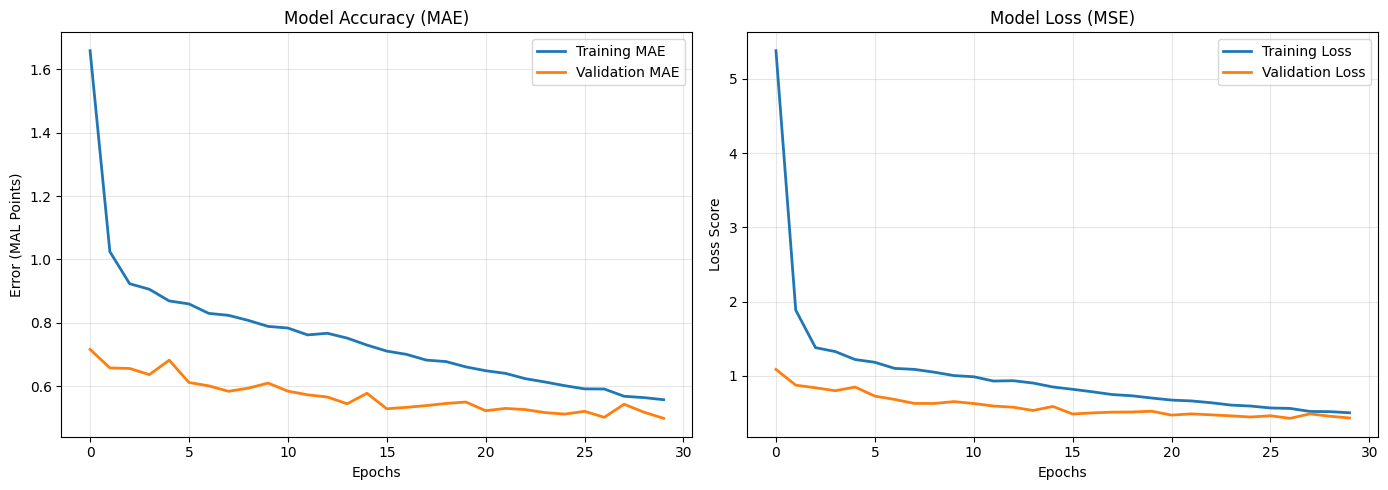

Final Test MAE: 0.4898


In [9]:
import matplotlib.pyplot as plt

# Set up the plotting area
plt.figure(figsize=(14, 5))

# Plot 1: Mean Absolute Error (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['mae'], label='Training MAE', color='#1f77b4', lw=2)
plt.plot(history.history['val_mae'], label='Validation MAE', color='#ff7f0e', lw=2)
plt.title('Model Accuracy (MAE)')
plt.xlabel('Epochs')
plt.ylabel('Error (MAL Points)')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Loss (Mean Squared Error)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#1f77b4', lw=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#ff7f0e', lw=2)
plt.title('Model Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final Evaluation on the 20% "Final Exam" data
final_results = model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test MAE: {final_results[1]:.4f}")

6. Interactive Prediction Demo

Phase 6: Interactive "What-If" Analysis
Use the interface below to test hypothetical anime configurations.

This demo demonstrates the model's ability to perform Inference on user-provided data by mapping text inputs to the trained 995-feature vector.

In [11]:
# --- 1. PREDICTION FUNCTION ---
import numpy as np

def predict_my_anime(type_name, source, genre, studio, theme, year, episodes):
    # Create an empty row matching the training features
    input_data = pd.DataFrame(np.zeros((1, X.shape[1])), columns=X.columns)

    # Fill numeric data
    input_data['Released_Year'] = year
    input_data['Episodes'] = episodes

    # Map categorical inputs to One-Hot columns
    if f'Main_Type_{type_name}' in input_data.columns:
        input_data[f'Main_Type_{type_name}'] = 1
    if f'Main_Source_{source}' in input_data.columns:
        input_data[f'Main_Source_{source}'] = 1
    if f'Main_Genre_{genre}' in input_data.columns:
        input_data[f'Main_Genre_{genre}'] = 1
    if f'Main_Studio_{studio}' in input_data.columns:
        input_data[f'Main_Studio_{studio}'] = 1
    if f'Main_Theme_{theme}' in input_data.columns:
        input_data[f'Main_Theme_{theme}'] = 1

    # Scale the input using the same parameters as the training data
    input_scaled = scaler.transform(input_data)

    # Predict
    prediction = model.predict(input_scaled, verbose=0)
    return prediction[0][0]

# --- 2. INTERACTIVE UI ---
# @title 📺 Ultimate Anime Score Predictor
# Fill these out to test your most niche anime ideas!

Type = "TV" # @param ["TV", "Movie", "OVA", "ONA", "Special", "Music"]
Source = "Manga" # @param ["Manga", "Original", "Light Novel", "Visual Novel", "Web manga", "Novel", "Game", "Other"]
Genre = "Fantasy" # @param ["Action", "Adventure", "Avant Garde", "Award Winning", "Boys Love", "Comedy", "Drama", "Ecchi", "Erotica", "Fantasy", "Girls Love", "Gourmet", "Horror", "Mystery", "Romance", "Sci-Fi", "Slice of Life", "Sports", "Supernatural", "Suspense"]
Theme = "Isekai" # @param ["Adult Cast", "Anthropomorphic", "CGDCT", "Childcare", "Combat Sports", "Detective", "Educational", "Gore", "Harem", "High Stakes Game", "Historical", "Idols (Female)", "Idols (Male)", "Isekai", "Iyashikei", "Love Polygon", "Magical Sex Shift", "Mahou Shoujo", "Martial Arts", "Mecha", "Medical", "Military", "Music", "Mythology", "Organized Crime", "Otaku Culture", "Parody", "Performing Arts", "Pets", "Psychological", "Racing", "Reincarnation", "Reverse Harem", "Romantic Subtext", "Samurai", "School", "Showbiz", "Space", "Strategy Game", "Super Power", "Survival", "Team Sports", "Time Travel", "Vampires", "Video Game", "Visual Arts", "Workplace", "None"]
Studio = "MAPPA" # @param ["Madhouse", "Sunrise", "Toei Animation", "Bones", "MAPPA", "A-1 Pictures", "Ufotable", "Kyoto Animation", "Wit Studio", "Shaft", "Production I.G", "J.C.Staff", "Studio Pierrot", "TMS Entertainment", "Studio Ghibli", "Shin-Ei Animation"]
Year = 2026 # @param {type:"slider", min:1960, max:2030, step:1}
Episodes = 24 # @param {type:"number"}

# Run the prediction using the function we built earlier
score = predict_my_anime(Type, Source, Genre, Studio, Theme, Year, Episodes)

print(f"--- PREDICTION RESULT ---")
print(f"Type: {Type} | Source: {Source} | Studio: {Studio}")
print(f"Genre: {Genre} | Theme: {Theme}")
print(f"Year: {Year} | Episodes: {Episodes}")
print(f"\nPredicted MAL Score: {score:.2f}")

--- PREDICTION RESULT ---
Type: TV | Source: Manga | Studio: MAPPA
Genre: Fantasy | Theme: Isekai
Year: 2026 | Episodes: 24

Predicted MAL Score: 7.33


Conclusion

Conclusion & Key Learnings


*   **Model Performance**: The model predicts anime scores with an average error of **0.48 points**

*   **Non-Linear Relationships**: I chose a Neural Network over a standard Linear Regression because the factors affecting anime popularity (like Studio reputation vs. Genre trends) are non-linear and complex.


*   **Feature Engineering**: One-Hot Encoding proved essential, turning categorical metadata into a 995-feature vector that the model could mathematically process.

*   **Future Improvements**: Adding user-review sentiment analysis or budget data could further refine the model's accuracy.